In [2]:
import numpy as np
import sympy as sp

%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pyJHTDB
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import interpolation_code
from pyJHTDB.dbinfo import isotropic1024coarse as info

import pickle
from time import time

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
nu = info['nu']
energy_diss = info['diss']
kolmogorov_time = (nu/energy_diss)**.5
kolmogorov_length = nu**(3/4.)*energy_diss**(-1/4.)

npoints = 2
nparticles = 100
nsteps = info['time'].shape[0] #total of 124

T = info['time'][-1];
subdivisions = 2
t = np.linspace(info['time'][-1], info['time'][0], num = subdivisions*nsteps+1)
tau = t[0]-t
dt              = t[0] - t[1]
sqrtdt          = abs(dt)**.5


x0 = np.zeros(shape = (npoints, nparticles, 3), dtype = np.float32)
x0[..., 0] = info['lx']*np.random.random(size = (npoints,))[:, None]
x0[..., 1] = info['ynodes'][info['ynodes'].shape[0]//2]
x0[..., 2] = info['lz']*np.random.random(size = (npoints,))[:, None]

x = x0.copy()
r = np.empty(shape = (npoints, nparticles,  nparticles), dtype = np.float32)
disp = np.empty(shape = (subdivisions*nsteps, npoints), dtype = np.float32)
numcombs =  nparticles*(nparticles-1)/2

In [7]:
PrandtlNumbers = np.array([1, 1/2., 1/10.])
for i in range(PrandtlNumbers.shape[0]):
    Prandtl = PrandtlNumbers[i]
    kappa = nu/Prandtl
    noiseamplitude  = (2*kappa)**.5
    lJHTDB = libJHTDB()
    lJHTDB.initialize()
    for tindex in range(subdivisions*nsteps):
        print('step {0} of {1} for Pr = {2}'.format(tindex,subdivisions*nsteps, Prandtl))
        u = lJHTDB.getData(
                    t[tindex],
                    x,
                    sinterp = interpolation_code['M2Q8'],
                    tinterp = interpolation_code['NoTInt'],
                    data_set = info['name'],
                    getFunction = 'getVelocity')
        dW = np.random.randn(*x.shape)*sqrtdt
        dX = -u*dt + noiseamplitude*dW
        x += dX
        for k in range(npoints):
            for i in range(nparticles):
                for j in range(nparticles):
                    if i<j:
                        r[k,i,j] =  np.sum(np.square(x[k, i, :] - x[k, j, :]))           
        disp = np.sum(np.sum(r, axis=2),axis=1)/numcombs
    lJHTDB.finalize()

    ####### Dump Data #######
    suffix = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl)
    pickle.dump(x, open( "data_isotropic/x"       + suffix, "wb" ) )
    pickle.dump(t, open( "data_isotropic/t"       + suffix, "wb" ) )
    pickle.dump(disp, open( "data_isotropic/disp" + suffix, "wb" ) )

step 0 of 2048
step 1 of 2048
step 2 of 2048
step 3 of 2048
step 4 of 2048


KeyboardInterrupt: 

In [52]:
####### Dump Data #######
#suffix = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl)
#pickle.dump(x, open( "data_isotropic/x"       + suffix, "wb" ) )
#pickle.dump(t, open( "data_isotropic/t"       + suffix, "wb" ) )
#pickle.dump(disp, open( "data_isotropic/disp" + suffix, "wb" ) )

####### Load Data #######
nparticles = 100
Prandtl1 = 1
Prandtl2 = 1/10.
suffix1 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl1)
suffix2 = 'Traj_{0}_Pr_{1}.p'.format(nparticles, Prandtl2)
t    = pickle.load( open( "data_isotropic/t"       + suffix1, "rb" ) )
disp1 = pickle.load( open( "data_isotropic/disp"    + suffix1, "rb" ) )
disp2 = pickle.load( open( "data_isotropic/disp"    + suffix2, "rb" ) )

<IPython.core.display.Javascript object>


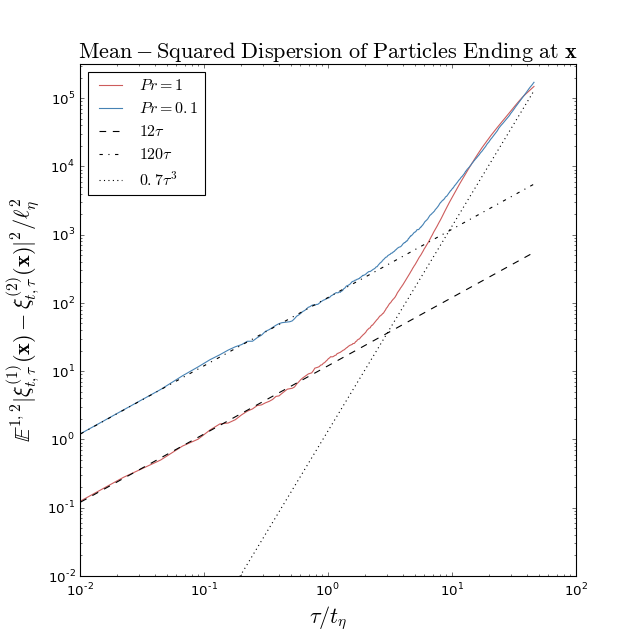

In [65]:
Tau = tau/kolmogorov_time
diffusion_dispersion1 = 12*Tau/Prandtl1
diffusion_dispersion2 = 12*Tau/Prandtl2
Richardson_dispersion = (4/3.)*Tau**3

space_point_index = 1
dispersion1 = disp1[:,space_point_index]/(kolmogorov_length**2)
disper1 = [0]
disper1.extend(dispersion1)

dispersion2 = disp2[:,space_point_index]/(kolmogorov_length**2)
disper2 = [0]
disper2.extend(dispersion2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.plot(Tau, disper1, color = 'Indianred', label = '$Pr = {0}$'.format(Prandtl1))
ax.plot(Tau, disper2, color = 'Steelblue', label = '$Pr = {0}$'.format(Prandtl2))
ax.plot(Tau, diffusion_dispersion1,   color = 'black', linestyle = 'dashed', label = '$12 \\tau$')
ax.plot(Tau, diffusion_dispersion2,   color = 'black', linestyle = 'dashdot', label = '$120 \\tau$')
ax.plot(Tau, Richardson_dispersion,  color = 'black', linestyle = 'dotted', label = '$0.7 \\tau^3$')
ax.set_ylim([10**(-2),10**(5.5)])
ax.set_title('$\\rm Mean-Squared\ Dispersion\ of\ Particles\ Ending\ at\ \\mathbf{x}$', fontsize=20)
ax.set_xlabel('$\\tau / t_\\eta$', fontsize=20)
ax.set_ylabel('$\mathbb{E}^{1,2} |{\\xi}^{(1)}_{t,\\tau}(\\mathbf{x})-{\\xi}^{(2)}_{t,\\tau}(\\mathbf{x})|^2 /\\ell_\\eta^2$', fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc ="best")